In [8]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import seaborn as sns
import yfinance as yf

import datetime
from dateutil.parser import parse

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm
from pmdarima.arima.utils import ndiffs

from prophet.plot import plot_plotly

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [9]:
# prompt:  Dataset Loading

# Load the dataset from a CSV file
df = pd.read_csv("/content/Netflix_stock_history.csv")

# Print the first five rows of the dataset
df.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,104790000,0,0.0
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,11104800,0,0.0
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,6609400,0,0.0
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,6757800,0,0.0
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,10154200,0,0.0


<Axes: xlabel='Open', ylabel='Close'>

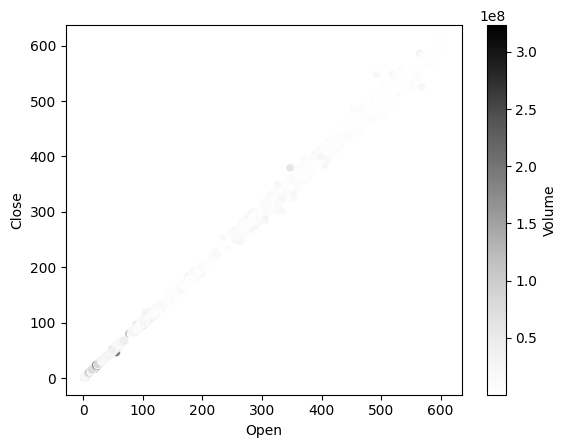

In [70]:
# @title Open vs Close

df.plot.scatter(x='Open', y='Close', c='Volume')

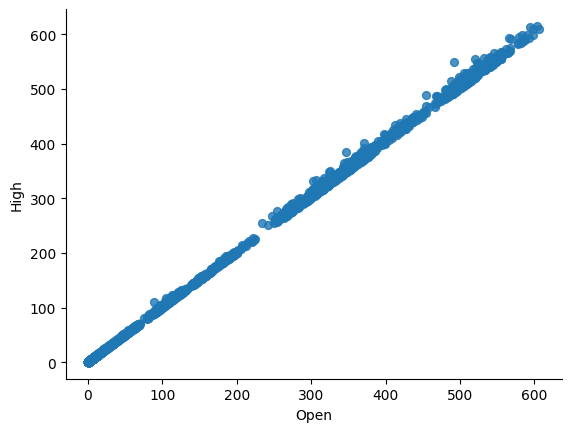

In [69]:
from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Open', y='High', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

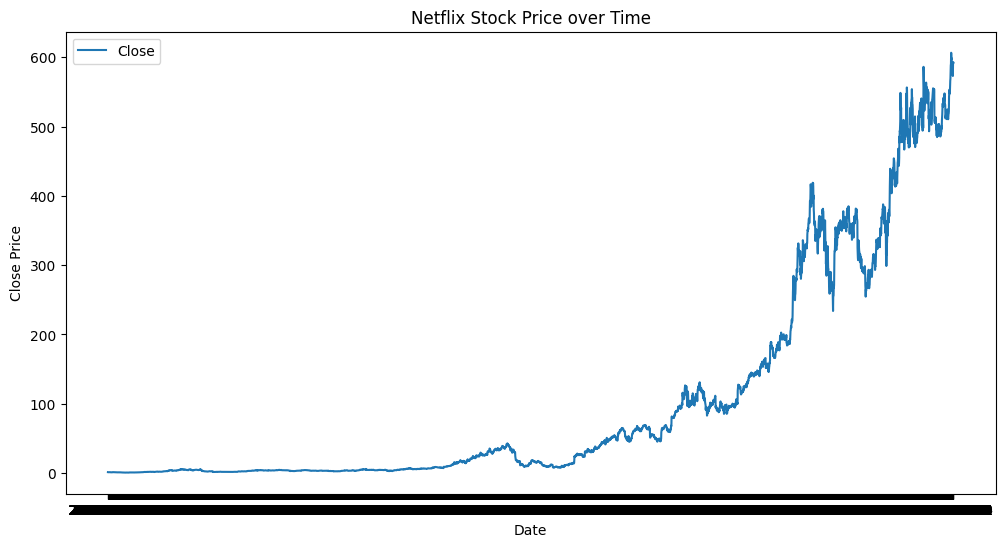

In [10]:
# Plot the closing price of the stock over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Netflix Stock Price over Time')
plt.legend()
plt.show()


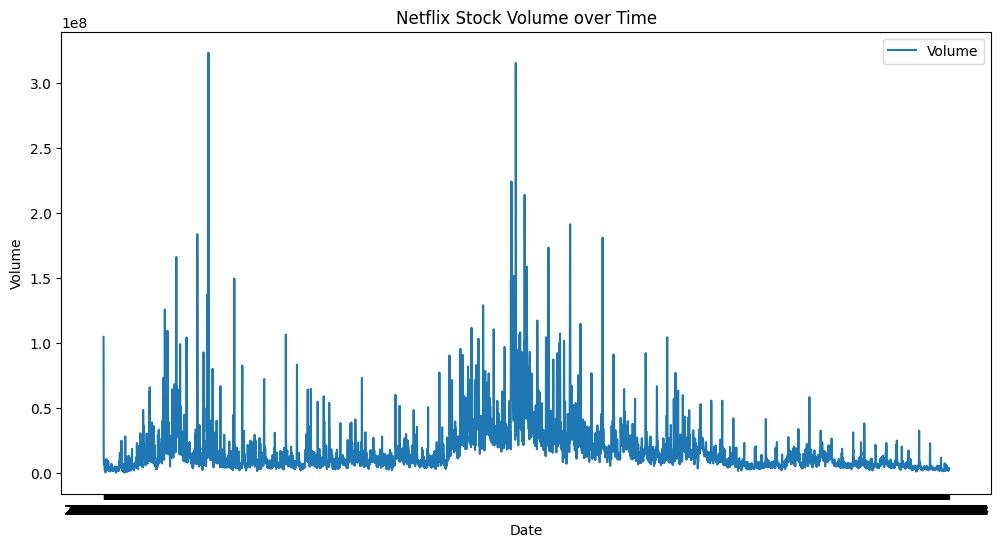

In [11]:
# Plot the volume of shares traded over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Volume'], label='Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Netflix Stock Volume over Time')
plt.legend()
plt.show()

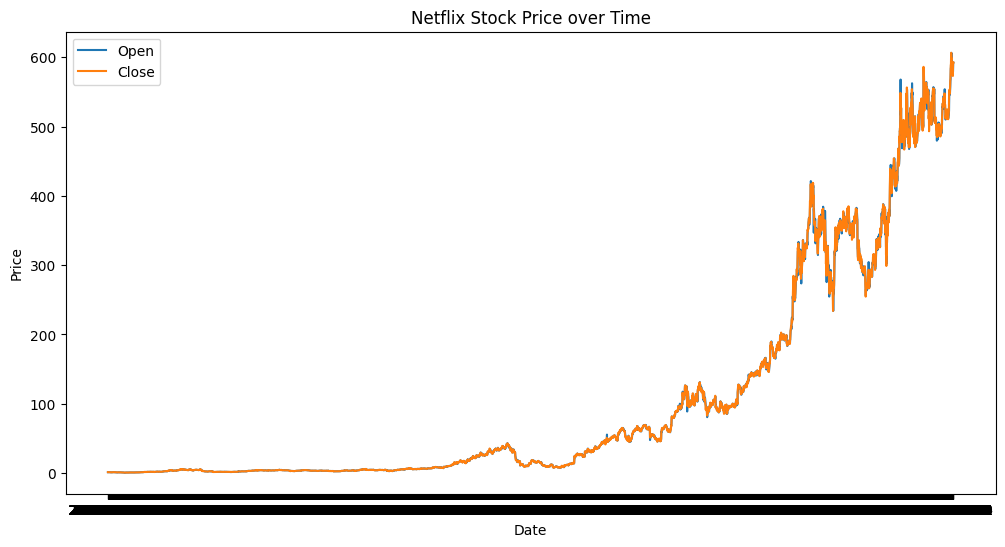

In [12]:
# prompt: Pandas Plotting for opening and closing prices

# Plot the opening and closing prices of the stock over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Open'], label='Open')
plt.plot(df['Date'], df['Close'], label='Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Netflix Stock Price over Time')
plt.legend()
plt.show()


In [13]:
# prompt: Plotly OHLC (Open-High-Low-Close) Charts

# Create an OHLC chart with plotly
import plotly.graph_objects as go

fig = go.Figure(data=[go.Ohlc(x=df['Date'],
                             open=df['Open'],
                             high=df['High'],
                             low=df['Low'],
                             close=df['Close'])])

fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()


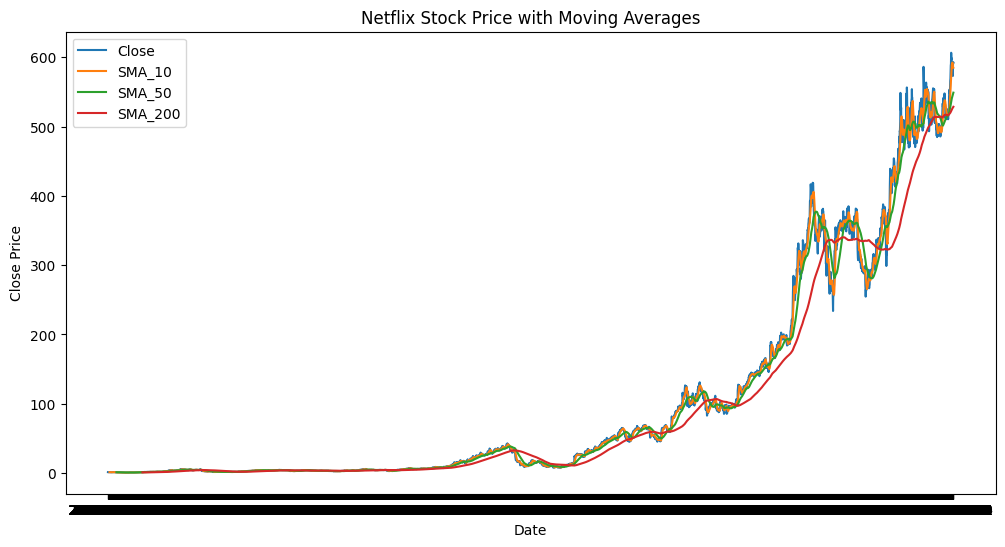

In [14]:
# prompt: Statistical Moving Average (SMA) Charts

# Calculate the 10-day SMA
df['SMA_10'] = df['Close'].rolling(window=10).mean()

# Calculate the 50-day SMA
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# Calculate the 200-day SMA
df['SMA_200'] = df['Close'].rolling(window=200).mean()

# Plot the closing price, 10-day SMA, 50-day SMA, and 200-day SMA
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['SMA_10'], label='SMA_10')
plt.plot(df['Date'], df['SMA_50'], label='SMA_50')
plt.plot(df['Date'], df['SMA_200'], label='SMA_200')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Netflix Stock Price with Moving Averages')
plt.legend()
plt.show()


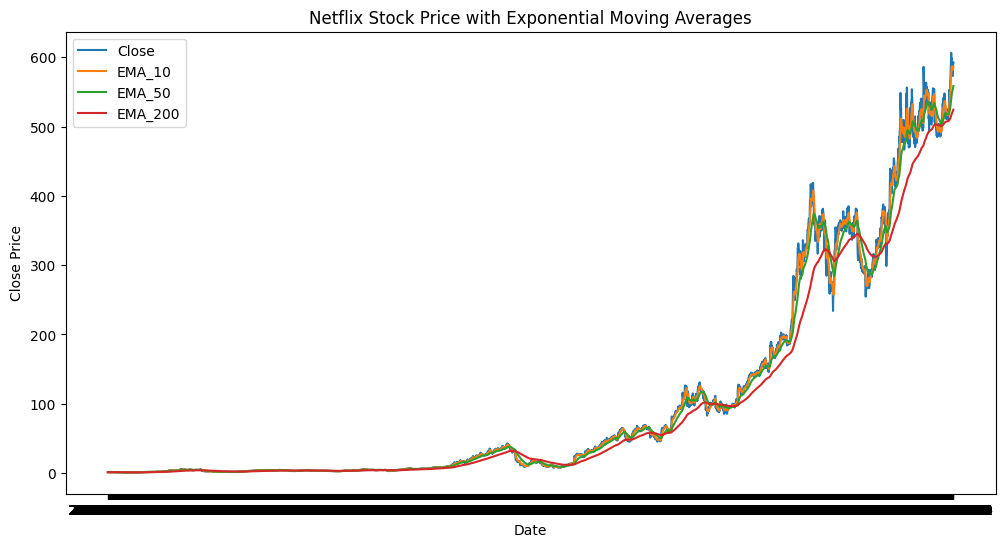

In [15]:
# prompt: Exponential Moving Average (EMA) Charts

# Calculate the 10-day EMA
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()

# Calculate the 50-day EMA
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

# Calculate the 200-day EMA
df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()

# Plot the closing price, 10-day EMA, 50-day EMA, and 200-day EMA
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['EMA_10'], label='EMA_10')
plt.plot(df['Date'], df['EMA_50'], label='EMA_50')
plt.plot(df['Date'], df['EMA_200'], label='EMA_200')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Netflix Stock Price with Exponential Moving Averages')
plt.legend()
plt.show()


In [16]:
# prompt: Reset the index on to the Date column

df = df.set_index('Date')


In [17]:
# prompt: Create a column on daily change percentages for the Stock with print

# Calculate the daily change percentages for the stock
df['Daily_Change_Percentage'] = (df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1) * 100

# Print the first five rows of the new column
print(df['Daily_Change_Percentage'].head())


Date
2002-05-23         NaN
2002-05-24    1.134294
2002-05-28   -4.368350
2002-05-29   -4.629673
2002-05-30   -2.912549
Name: Daily_Change_Percentage, dtype: float64


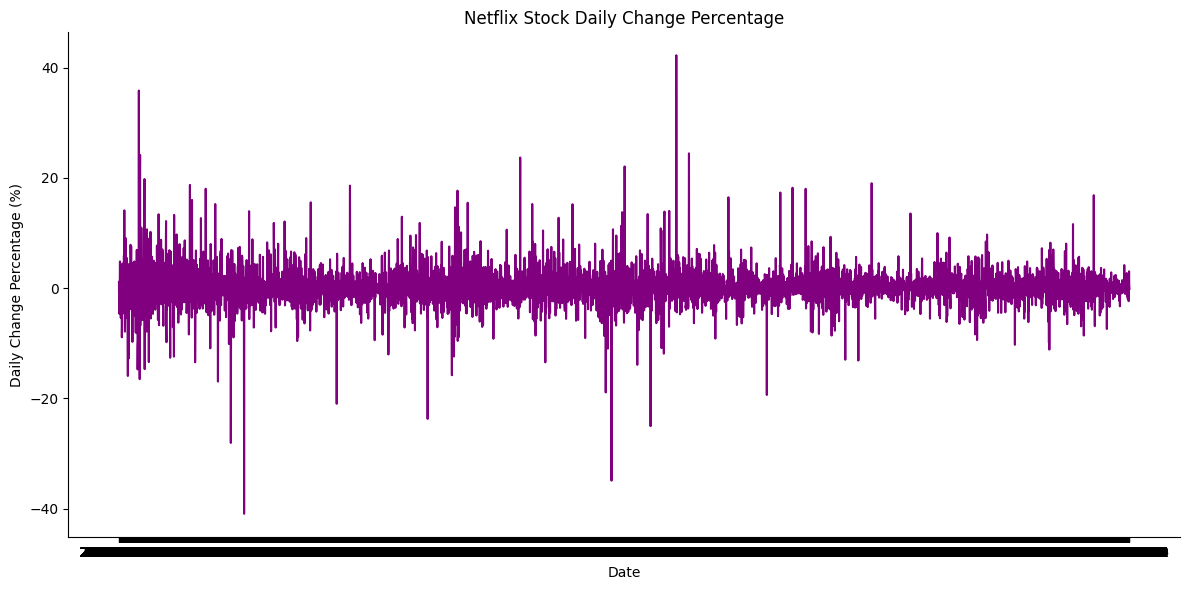

In [18]:
import seaborn as sns

# Create a new figure
fig = plt.figure(figsize=(12, 6))

# Plot the daily change percentages
sns.lineplot(data=df['Daily_Change_Percentage'], color='purple')

# Add a title and axis labels
plt.title('Netflix Stock Daily Change Percentage')
plt.xlabel('Date')
plt.ylabel('Daily Change Percentage (%)')

# Improve the aesthetics of the plot
sns.despine()
plt.tight_layout()

# Show the plot
plt.show()

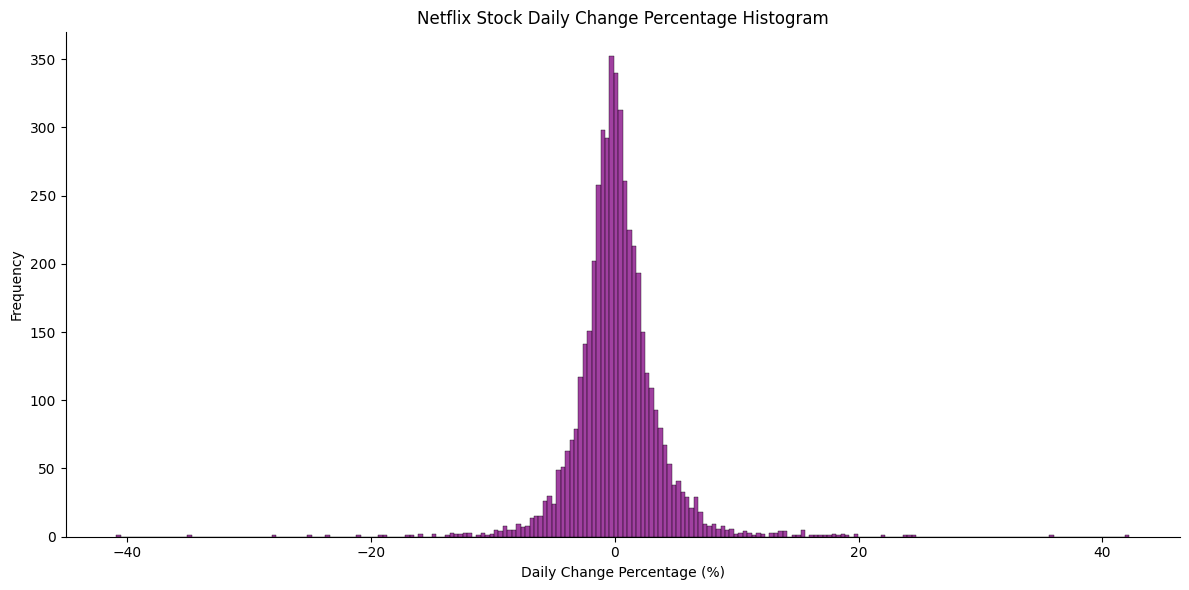

In [19]:
# prompt: Create a histogram on the daily changes / percentage

# Create a histogram of the daily change percentages
fig = plt.figure(figsize=(12, 6))
sns.histplot(data=df['Daily_Change_Percentage'], color='purple')

# Add a title and axis labels
plt.title('Netflix Stock Daily Change Percentage Histogram')
plt.xlabel('Daily Change Percentage (%)')
plt.ylabel('Frequency')

# Improve the aesthetics of the plot
sns.despine()
plt.tight_layout()

# Show the plot
plt.show()


<Axes: xlabel='Date'>

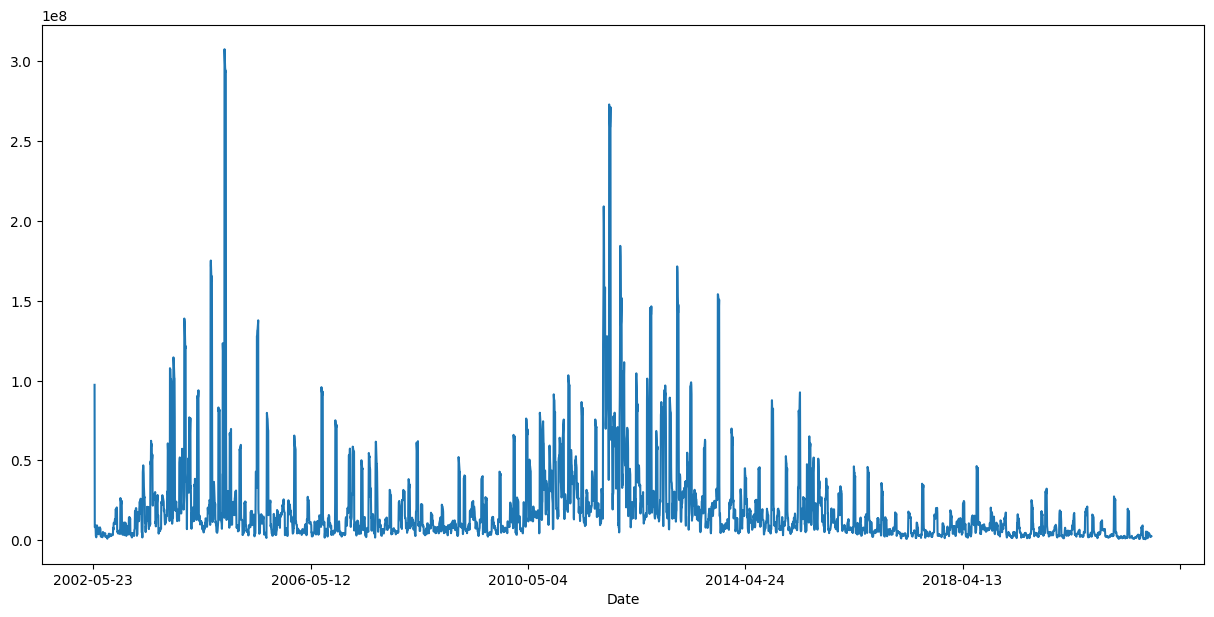

In [23]:
# prompt: Plot 7-day rolling averages for volume of stocks traded

nvol = df['Volume'].rolling(7).std()*np.sqrt(7)
nvol.plot(figsize = (15, 7))


In [24]:
# prompt: Define a daily trend function for usage in aggregation

def daily_trend(df):
  return df.groupby(df.index.date)['Close'].mean()


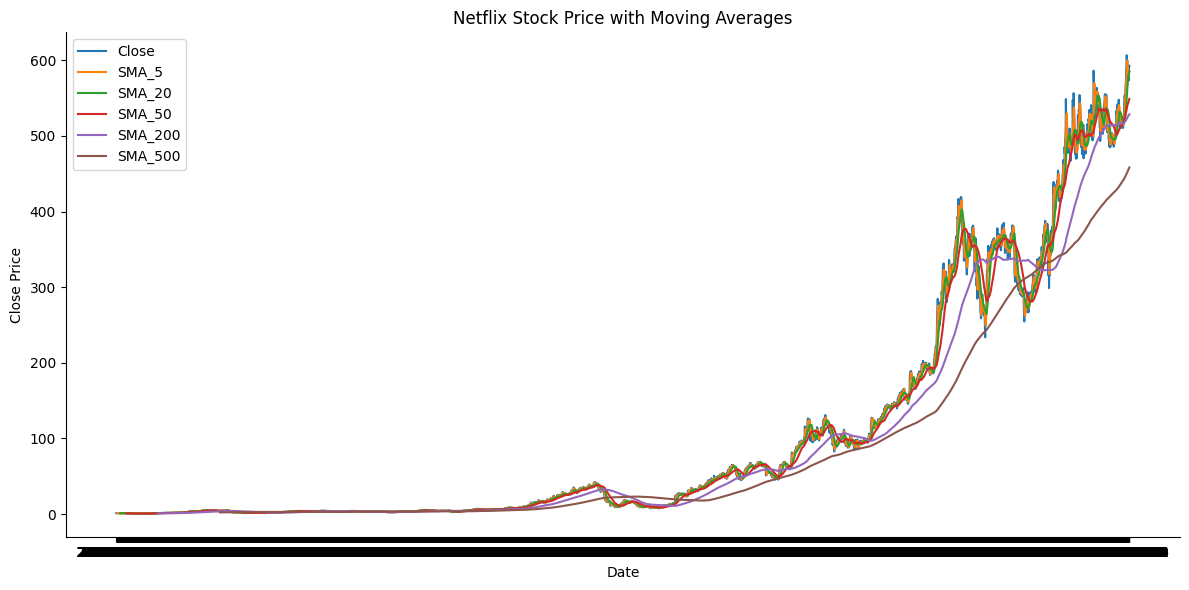

In [25]:
# prompt: SMA chart plotting for 5, 20, 50, 200, 500 day moving averages

# Calculate the moving averages
df['SMA_5'] = df['Close'].rolling(window=5).mean()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()
df['SMA_500'] = df['Close'].rolling(window=500).mean()

# Create a new figure
fig = plt.figure(figsize=(12, 6))

# Plot the closing price and moving averages
plt.plot(df['Close'], label='Close')
plt.plot(df['SMA_5'], label='SMA_5')
plt.plot(df['SMA_20'], label='SMA_20')
plt.plot(df['SMA_50'], label='SMA_50')
plt.plot(df['SMA_200'], label='SMA_200')
plt.plot(df['SMA_500'], label='SMA_500')

# Add a title and axis labels
plt.title('Netflix Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Add a legend
plt.legend()

# Improve the aesthetics of the plot
sns.despine()
plt.tight_layout()

# Show the plot
plt.show()


In [27]:
# Change the labels to match the number of bins - 1
df['Daily_Change_Category'] = pd.cut(df['Daily_Change_Percentage'], bins=[-np.inf, -5, -2.5, 0, 2.5, 5, np.inf], labels=['Large Decrease', 'Decrease', 'Slight Decrease', 'No Change', 'Slight Increase', 'Increase'])

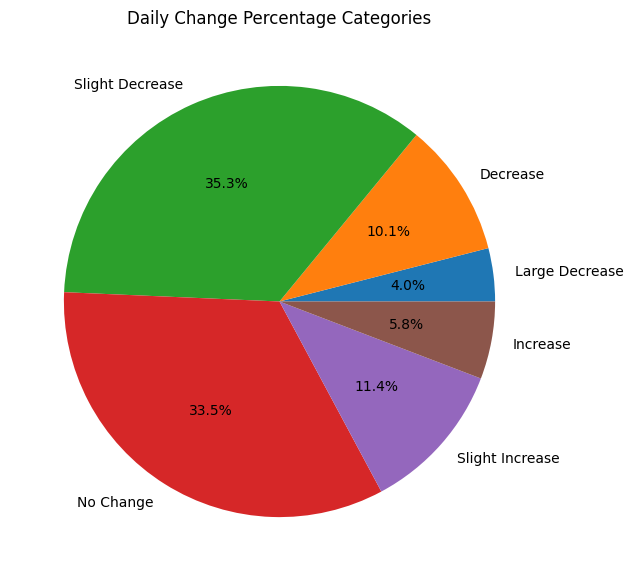

In [30]:
# prompt: A Pie & Bar Chart of Daily Percentage change categories

# Calculate the daily change percentages for the stock
df['Daily_Change_Percentage'] = (df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1) * 100

# Create a new column for the categories of daily change percentages
# Change the labels to match the number of bins - 1
df['Daily_Change_Category'] = pd.cut(df['Daily_Change_Percentage'], bins=[-np.inf, -5, -2.5, 0, 2.5, 5, np.inf], labels=['Large Decrease', 'Decrease', 'Slight Decrease', 'No Change', 'Slight Increase', 'Increase'])

# Group the data by the daily change category
grouped_data = df.groupby('Daily_Change_Category').size()

# Create a pie chart of the daily change categories
fig = plt.figure(figsize=(15, 7))
plt.pie(grouped_data, labels=grouped_data.index, autopct='%1.1f%%')
plt.title('Daily Change Percentage Categories')
plt.show()


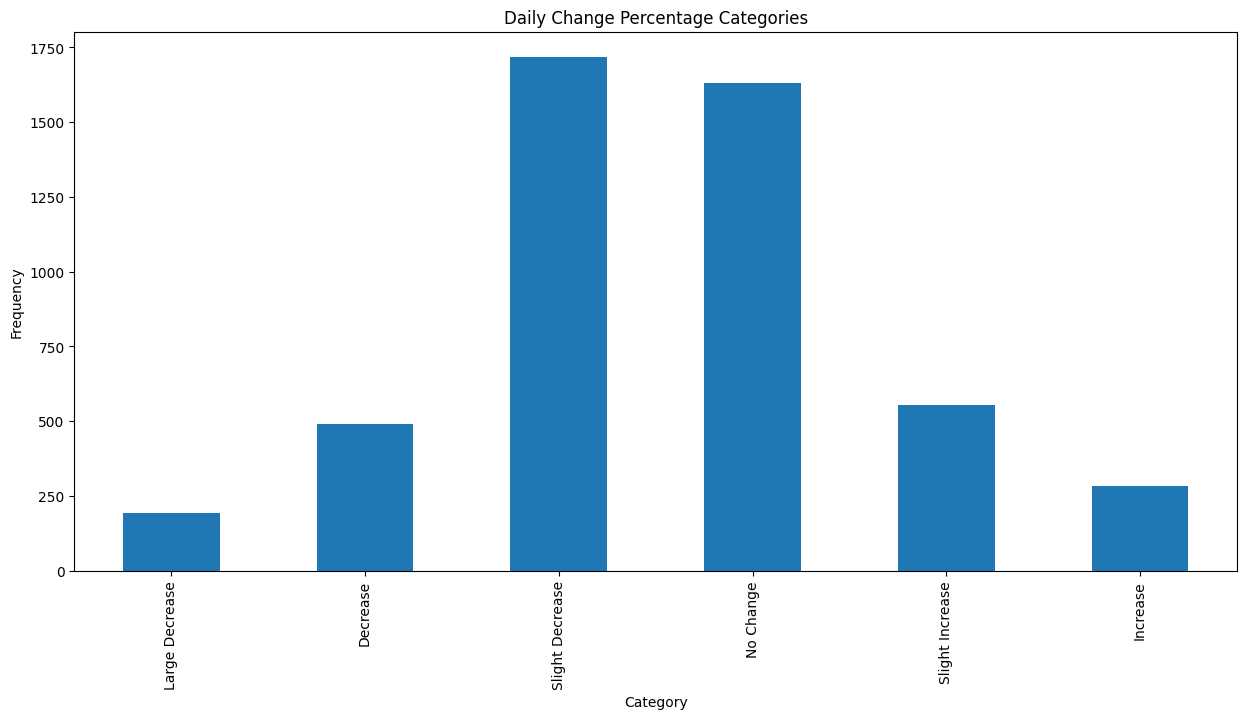

In [31]:
# Create a bar chart of the daily change categories
fig = plt.figure(figsize=(15, 7))
grouped_data.plot(kind='bar')
plt.title('Daily Change Percentage Categories')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

In [33]:
# prompt: Checking for stationarity using Augmented Dickey Fuller Test

from statsmodels.tsa.stattools import adfuller

def adf_check(timeseries):
    result = adfuller(timeseries)
    print("Augmented Dickey-Fuller Test:")
    labels = ['ADF Statistic', 'p-value', '#Lags', 'No. of Observations Used']
    for i, j in zip(result, labels):
        print(f"{j:25} = {i}")

adf_check(df['Close'])


Augmented Dickey-Fuller Test:
ADF Statistic             = 2.6383546481598774
p-value                   = 0.9990812682590638
#Lags                     = 30
No. of Observations Used  = 4839


In [34]:
# prompt: Differencing the data to make it stationary:

df['Close_diff'] = df['Close'] - df['Close'].shift(1)
adf_check(df['Close_diff'].dropna())


Augmented Dickey-Fuller Test:
ADF Statistic             = -12.523975906362448
p-value                   = 2.5123294261035246e-23
#Lags                     = 32
No. of Observations Used  = 4836


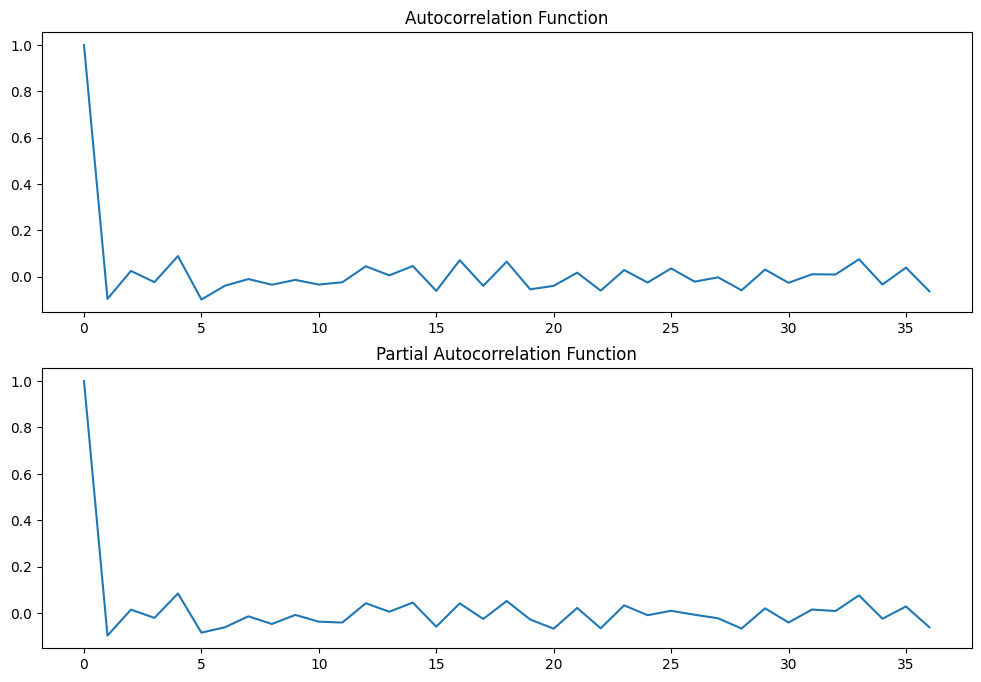

In [37]:
# prompt: Plotting Autocorrelation and Partial Autocorreltion functions to find the number of lags:

from statsmodels.tsa.stattools import acf, pacf

# Calculate the autocorrelation and partial autocorrelation functions
acf_values = acf(df['Close_diff'].dropna())
pacf_values = pacf(df['Close_diff'].dropna())

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot the autocorrelation function on the first subplot
ax1.plot(acf_values)
ax1.set_title('Autocorrelation Function')

# Plot the partial autocorrelation function on the second subplot
ax2.plot(pacf_values)
ax2.set_title('Partial Autocorrelation Function')

# Show the plot
plt.show()


In [40]:
model_auto_arima = pm.auto_arima(df['Close'], start_p=1, start_q=1,
                      test='adf',       # use adfuller test to find optimal 'd'
                      max_d=3,          # maximum 'd'
                      max_p=5,          # maximum 'p'
                      max_q=5,          # maximum 'q'
                      start_P=0,
                      D=None,
                      trace=True,
                      stepwise=True)

print("Auto-ARIMA Model Order:", model_auto_arima.order)

model_auto_arima.summary()


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=28678.411, Time=4.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28734.562, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28691.968, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=28693.622, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=28735.917, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=28674.417, Time=4.70 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=28692.710, Time=0.87 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=28672.350, Time=5.85 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=28692.827, Time=0.92 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=28647.548, Time=4.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=28658.966, Time=1.36 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=28603.306, Time=6.80 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=28627.342, Time=1.89 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=28605.306, Time=14.94 sec
 ARIMA(4,1,2)(0,0,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4870
Model:               SARIMAX(5, 1, 1)   Log Likelihood              -14293.653
Date:                Thu, 25 Apr 2024   AIC                          28603.306
Time:                        23:31:53   BIC                          28655.231
Sample:                             0   HQIC                         28621.530
                               - 4870                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0520      0.023      2.241      0.025       0.007       0.097
ar.L1          0.5724      0.031     18.303      0.000       0.511       0.634
ar.L2          0.0725      0.007      9.950      0.000       0.058       0.087
ar.L3         -0.0189      0.008     -2.512      0.012      -0.034      -0.004
ar.L4          0.0858      0.007     11.729      0.000       0.071       0.100
ar.L5         -0.1393      0.005    -26.095      0.000      -0.150      -0.129
ma.L1         -0.6653      0.031    -21.133      0.000      -0.727      -0.604
sigma2        20.7671      0.096    216.460      0.000      20.579      20.955
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            373440.72
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):            1564.57   Skew:                             0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        45.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
# Import the correct ARIMA class
from statsmodels.tsa.arima.model import ARIMA

# Build the ARIMA model with the correct class name
model_arima = ARIMA(df['Close'], order=(2, 1, 2))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4870
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -14333.609
Date:                Thu, 25 Apr 2024   AIC                          28677.217
Time:                        23:33:32   BIC                          28709.670
Sample:                             0   HQIC                         28688.607
                               - 4870                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7055      0.170     -4.152      0.000      -1.039      -0.373
ar.L2          0.1483      0.134      1.106      0.269      -0.115       0.411
ma.L1          0.6163      0.170      3.634      0.0

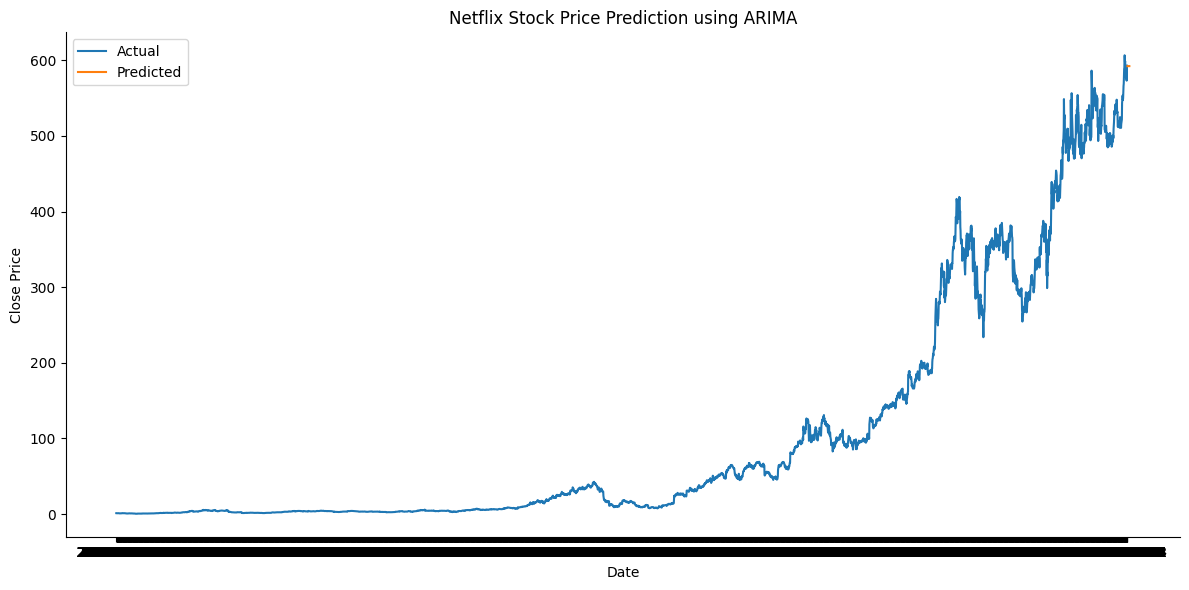

In [46]:
# Make predictions using the ARIMA model
forecast_horizon = 10
arima_forecast = model_arima_fit.forecast(steps=forecast_horizon)

# Create a new figure
fig = plt.figure(figsize=(12, 6))

# Plot the actual data
plt.plot(df['Close'], label='Actual')

# Plot the predicted data
plt.plot(arima_forecast, label='Predicted')

# Add a title and axis labels
plt.title('Netflix Stock Price Prediction using ARIMA')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Add a legend
plt.legend()

# Improve the aesthetics of the plot
sns.despine()
plt.tight_layout()

# Show the plot
plt.show()


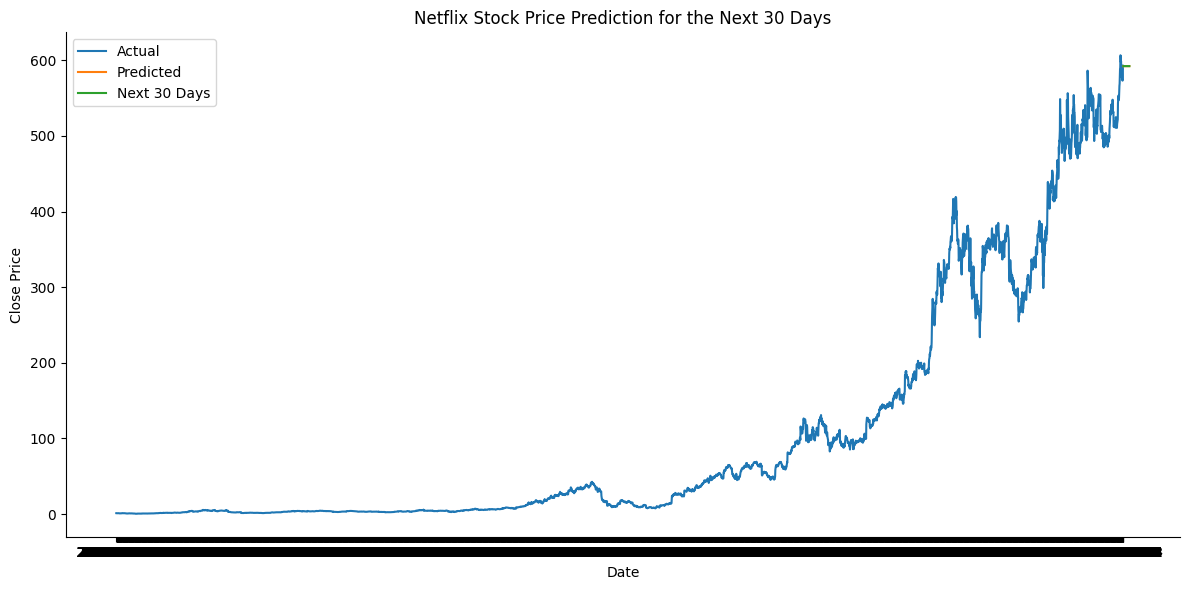

In [49]:
# Create a new figure
fig = plt.figure(figsize=(12, 6))

# Plot the actual data
plt.plot(df['Close'], label='Actual')

# Plot the predicted data
plt.plot(arima_forecast, label='Predicted')

# Forecast the next 30 days
next_30_days = arima_forecast[-30:]

# Plot the next 30 days
plt.plot(next_30_days, label='Next 30 Days')

# Add a title and axis labels
plt.title('Netflix Stock Price Prediction for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Add a legend
plt.legend()

# Improve the aesthetics of the plot
sns.despine()
plt.tight_layout()

# Show the plot
plt.show()


In [51]:
fc = model_arima_fit.forecast(30, alpha=0.05)
for i in fc:
    print(round(i,0))


592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0
592.0


In [53]:
# Extract the forecasted values for the next 3 days
next_3_days_forecast = arima_forecast[:3]

# Print the forecasted values
for i in next_3_days_forecast:
  print(round(i, 0))



592.0
592.0
592.0


In [59]:
date_range = pd.date_range(start='2022-02-05', periods=3)

# Create a new dataframe with the forecasted values and the corresponding dates
forecast_df = pd.DataFrame({'Date': date_range, 'Close': next_3_days_forecast})

# Print the forecast_df
print(forecast_df)

           Date       Close
4870 2022-02-05  592.309021
4871 2022-02-06  592.359451
4872 2022-02-07  592.311861


In [60]:
# Extract the forecasted values for the next 30 days
next_30_days_forecast = arima_forecast[-30:]

# Extract the forecasted values for the next 3 days
next_3_days_forecast = next_30_days_forecast[:3]

# Create a date range from '2022-02-05' to '2022-02-07'
date_range = pd.date_range(start='2022-02-05', periods=3)

# Create a new dataframe with the forecasted values and the corresponding dates
forecast_df = pd.DataFrame({'Date': date_range, 'Close': next_3_days_forecast})

# Print the forecast_df
print(forecast_df)

           Date       Close
4870 2022-02-05  592.309021
4871 2022-02-06  592.359451
4872 2022-02-07  592.311861


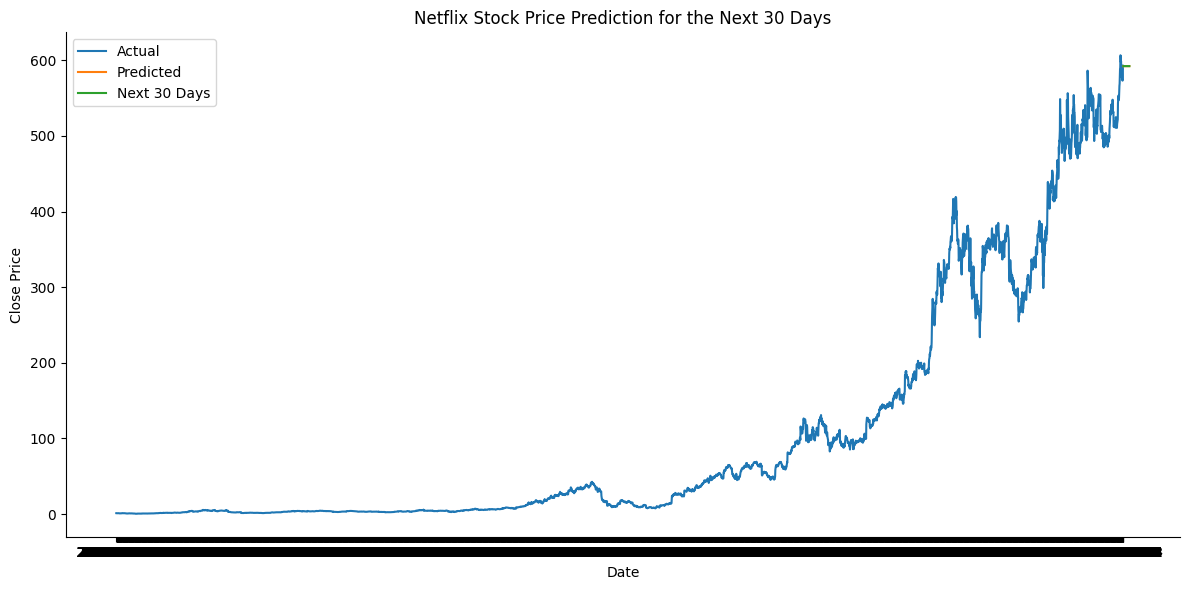

In [61]:
# Create a new figure
fig = plt.figure(figsize=(12, 6))

# Plot the actual data
plt.plot(df['Close'], label='Actual')

# Plot the predicted data
plt.plot(arima_forecast, label='Predicted')

# Forecast the next 30 days
next_30_days = arima_forecast[-30:]

# Plot the next 30 days
plt.plot(next_30_days, label='Next 30 Days')

# Add a title and axis labels
plt.title('Netflix Stock Price Prediction for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Add a legend
plt.legend()

# Improve the aesthetics of the plot
sns.despine()
plt.tight_layout()

# Show the plot
plt.show()


<Axes: xlabel='Date'>

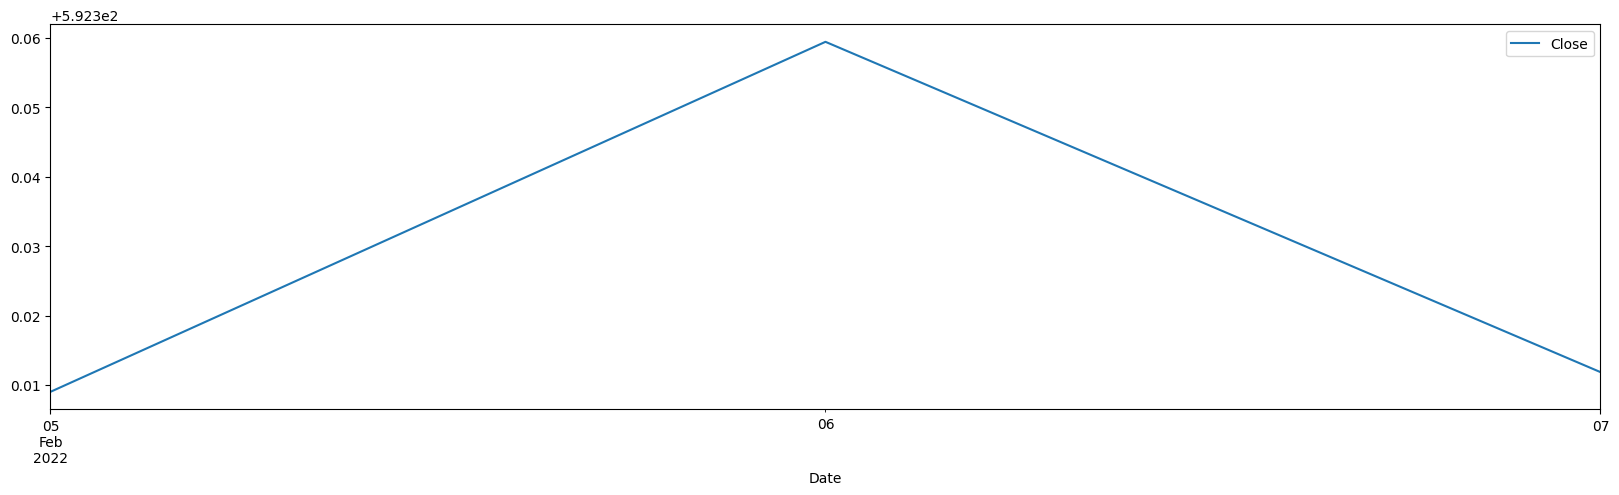

In [63]:
forecast_df.plot(x='Date', y='Close', figsize=(20,5))


In [66]:
print(df.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'SMA_10', 'SMA_50', 'SMA_200', 'EMA_10', 'EMA_50', 'EMA_200',
       'Daily_Change_Percentage', 'Volume_7_Day_Rolling_Avg',
       'Volume_30_Day_Rolling_Avg', 'Volume_60_Day_Rolling_Avg',
       'Volume_90_Day_Rolling_Avg', 'Volume_7_Day_Rolling_Average', 'SMA_5',
       'SMA_20', 'SMA_500', 'Daily_Change_Category', 'Close_diff'],
      dtype='object')
